# Small World Features 

By: Jimuel Celeste, Jr., jimueljr@ualberta.ca 

Objective: To extract small-world features from speech data. 

In [3]:
from networkx.algorithms.smallworld import sigma
from networkx.algorithms.smallworld import omega
from pydub import AudioSegment
from scipy.io.wavfile import read
from scipy.signal.windows import hamming
from ts2vg import NaturalVG

import matplotlib.pyplot as plt
import networkx as nx 
import numpy as np 
import pandas as pd
import seaborn as sns
import wave

from vad_segmentation import *

In [4]:
sns.set_context('talk')
sns.set_style('white')

## Read wav

In [48]:
def get_wav_properties(file):
    with wave.open(file, 'rb') as audio_file:
        n_channels = audio_file.getnchannels()
        sample_width = audio_file.getsampwidth()
        frame_rate = audio_file.getframerate()
        n_frames = audio_file.getnframes()
        
        print(f"Channels: {n_channels}")
        print(f"Sample Width (bytes): {sample_width}")
        print(f"Frame Rate (Hz): {frame_rate}")
        print(f"Number of Frames: {n_frames}")

        return (n_channels, sample_width, frame_rate, n_frames)
    
def get_wav_data(file):
    frame_rate, data = read(file)
    return frame_rate, data

In [49]:
sample = '/Users/jimuelcelestejr/Documents/codebook/small_world_network/data/taukdial-003-1.wav'
get_wav_properties(sample)

Channels: 2
Sample Width (bytes): 2
Frame Rate (Hz): 48000
Number of Frames: 1041193


(2, 2, 48000, 1041193)

In [50]:
frame_rate, data_arr = get_wav_data(sample)
frame_rate, data_arr

(48000,
 array([[  27,   26],
        [  30,   28],
        [  31,   30],
        ...,
        [-178, -177],
        [-178, -176],
        [-177, -175]], shape=(1041193, 2), dtype=int16))

There are 2 channels for this file. For this analysis, mono-channel is needed. Next step is conversion.

## Convert: stereo to mono; 48 kHz to 16 kHz

In [51]:
def convert_wav_stereo_to_mono_channel(input_file, output_file):
    sound = AudioSegment.from_wav(input_file)
    sound = sound.set_channels(1) # 1 channel
    sound = sound.set_frame_rate(16000) # 16 kHz
    sound = sound.set_sample_width(2) # 16 bit
    sound.export(output_file, format="wav")
    return None

sample_mono = '/Users/jimuelcelestejr/Documents/codebook/small_world_network/data/taukdial-003-1_mono.wav'
convert_wav_stereo_to_mono_channel(sample, sample_mono)

In [52]:
get_wav_properties(sample_mono)

Channels: 1
Sample Width (bytes): 2
Frame Rate (Hz): 16000
Number of Frames: 347065


(1, 2, 16000, 347065)

In [53]:
frame_rate, data_mono = get_wav_data(sample_mono)
frame_rate, data_mono

(16000,
 array([  26,   32,   36, ..., -186, -180, -176],
       shape=(347065,), dtype=int16))

## VAD Segmentation

Voiced regions will be taken extracted from the data

In [98]:
def get_wav_binary(file):
    with wave.open(file, 'rb') as audio_file:
        binary, frame_rate = read_wave(file)
        return frame_rate, binary

def get_vad_segments(audio_binary, frame_rate, intensity=2, frame_generator_ms=30,
                    frame_duration_ms=30, padding_duration_ms=300):
    vad = webrtcvad.Vad(intensity)
    frames = frame_generator(frame_generator_ms, audio_binary, frame_rate)
    frames = list(frames)
    segments = vad_collector(frame_rate, frame_duration_ms, padding_duration_ms, vad, frames)
    return segments

def ms_to_frame(duration_in_seconds, frame_rate):
    n_frames = int(round(duration_in_seconds * frame_rate))
    return n_frames
    
def get_voiced_data(file):
    # Getting voiced segments from binary file
    frame_rate, binary = get_wav_binary(file)
    segments = get_vad_segments(binary, frame_rate)

    # wav array
    _, data = get_wav_data(file)   
    n_frames = len(data)

    # Getting voiced segments from wav array
    voiced_data = []
    for i, segment in enumerate(segments):
        start, end = segment 
        start_index = ms_to_frame(start, frame_rate)
        end_index = ms_to_frame(end, frame_rate)
        voiced_data.extend(data[start_index:end_index])
    return voiced_data

voiced_data = get_voiced_data(sample_mono)
len(voiced_data)

000000000000111000000000000000000000000000000000001111111111+(1.500000000000001)111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000000000-(4.949999999999997)000000001111111111+(5.189999999999999)1111111111111111110000000000-(6.330000000000008)00000000000000000000000000001111111111+(7.170000000000015)111111111101111111111111111111111111111111111111111110000000000-(9.359999999999992)00000000000001111111111+(9.749999999999984)111111111111111111111110000000000-(11.039999999999957)001111111111+(11.099999999999955)11111111111111111111111111111111111111111100000000011111111111111111111111111111111111111111111111111111111111111111111111111111111110000000000-(15.689999999999857)1111111111+(15.689999999999857)111111111111111111111111110000000000-(17.06999999999989)0000000000000000000000000000000000000000000000000000000000001111111111+(18.86999999999996)11111111111111111111111111111111110000000000-(20.49000000000002)000000000000000000000000000000000

250560

In [99]:
len(voiced_data), len(data_mono), len(data_mono) - len(voiced_data)

(250560, 347065, 96505)

96K frames removed in this process.

## Hamming Window

Non-overlapping 50ms hamming windows

seconds = frames / frame_rate

In [100]:
window_size = ms_to_frame(0.05, frame_rate) # 5ms
stride_size = ms_to_frame(0.05, frame_rate) # 5ms
window_size, stride_size

(800, 800)

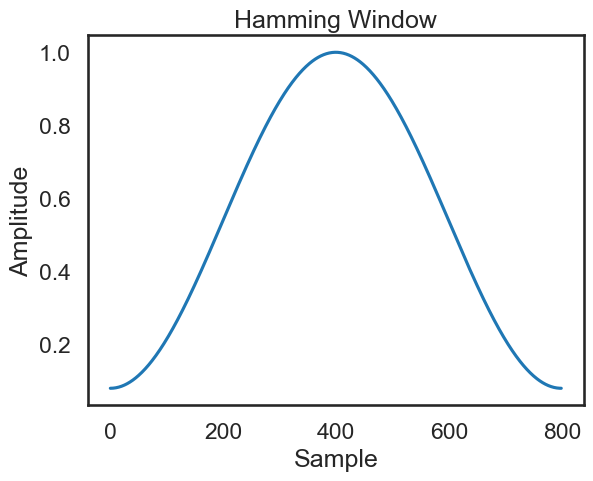

In [108]:
hamming_window = hamming(window_size)
plt.plot(hamming_window)
plt.title("Hamming Window")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.savefig('../results/Thesis - Figures/hamming_window.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [109]:
def frame_to_ms(n_frames, frame_rate):
    duration_in_seconds = n_frames / frame_rate
    return duration_in_seconds 

frame_to_ms(window_size, frame_rate)

0.05

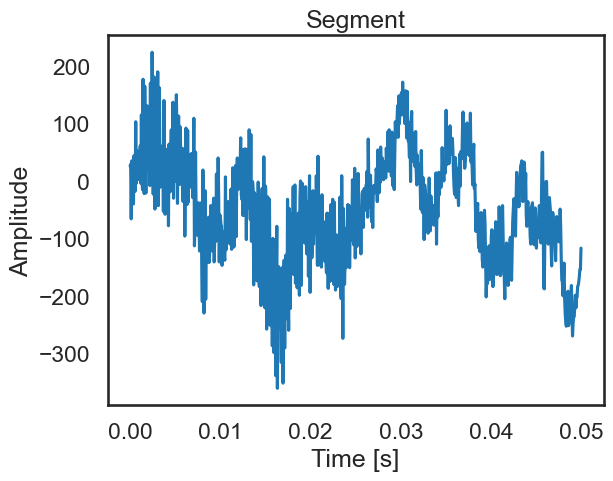

In [152]:
start = 20500
sample_segment = voiced_data[start:start+window_size]
duration = frame_to_ms(window_size, frame_rate)
time_array = np.arange(0, duration, 1 / frame_rate)
plt.plot(time_array, sample_segment)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Segment')
plt.savefig('../results/Thesis - Figures/segment.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

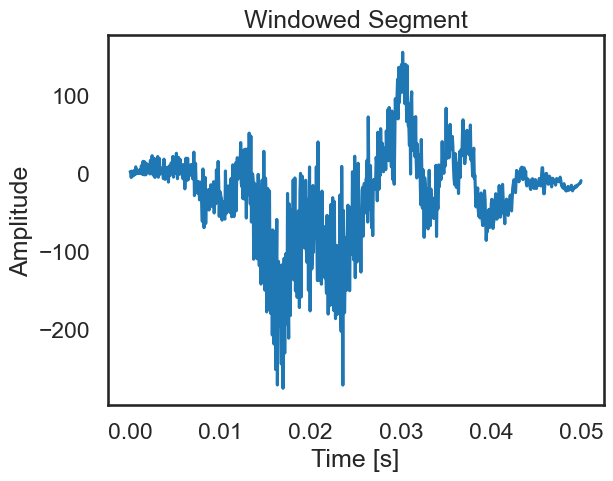

In [153]:
windowed_segment = sample_segment * hamming_window
plt.plot(time_array, windowed_segment)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Windowed Segment')
plt.savefig('../results/Thesis - Figures/windowed_segment.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

## Time Series to Weighted Visibility Graph

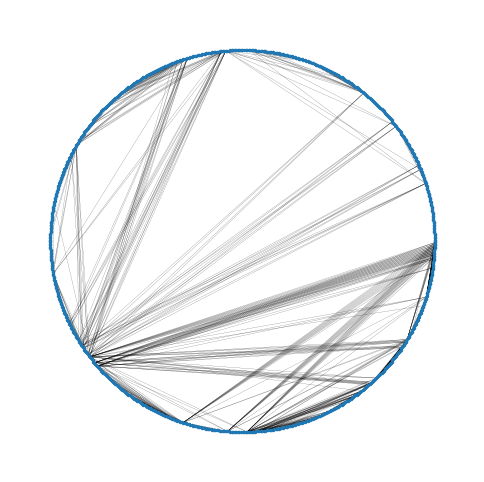

In [154]:
vg = NaturalVG(weighted='angle') # see: https://cbergillos.com/ts2vg/api/graph_options.html#weighted-graphs
vg.build(windowed_segment)
g = vg.as_networkx()
plt.figure(figsize=(6, 6))
pos = nx.circular_layout(g)
nx.draw_networkx_nodes(g, pos, node_color='C0', node_size=1)
nx.draw_networkx_edges(g, pos, edge_color='black', width=0.1)
plt.box(False)
plt.savefig('../results/Thesis - Figures/visibility_graph.png', dpi=300, transparent=True, bbox_inches='tight')

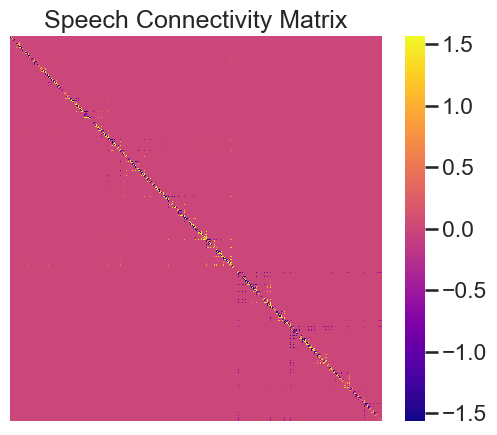

In [159]:
adjacency_matrix = nx.adjacency_matrix(g).toarray()
plt.figure(figsize=(6, 5))
sns.heatmap(adjacency_matrix, annot=False, cmap='plasma', 
    xticklabels=False, yticklabels=False)
plt.title('Speech Connectivity Matrix')
plt.savefig('../results/Thesis - Figures/adjacency_matrix.png', dpi=300, transparent=True, bbox_inches='tight')

## Extract Features

### Average Path Length (L)

In [160]:
%%time
L = nx.average_shortest_path_length(g)
L

CPU times: user 592 ms, sys: 5.54 ms, total: 597 ms
Wall time: 596 ms


4.604455569461828

### Clustering Coefficient (C)

In [161]:
%%time
C = nx.average_clustering(g)
C

CPU times: user 38.2 ms, sys: 3.49 ms, total: 41.7 ms
Wall time: 63.4 ms


0.7466057723317752

### Small-worldness Index $\sigma$ and $\omega$

Calculating sigma and omega with the default parameters takes a very long time, even for a sample with window length of 100. It is an open problem, I believe, as others have also pointed out (e.g. one had to run the code for 50hrs for a 300x300 graph. See:

1. https://neurostars.org/t/the-computation-time-of-small-world-coefficient/27258
2. https://stackoverflow.com/questions/65286415/compute-small-world-coefficients-with-networkx

Only C and L will be included in this version.

In [ ]:
# S = nx.sigma(g)
# O = nx.omega(g)

In [162]:
%%time
S = nx.sigma(g, niter=1, nrand=1, seed=None)
S

CPU times: user 1min 38s, sys: 630 ms, total: 1min 39s
Wall time: 1min 40s


10.189078973722024

In [170]:
# Estimated processing time for the sample file
len(data_mono) / window_size * 1.4 / 60

10.122729166666666

Estimated 10 hours of processing for one file, and that is if niter=1 and nrand=1. The default is niter=100, nrand=10.

## Functionals

In [217]:
def get_wvg(data):
    vg = NaturalVG(weighted='angle')
    vg.build(data)
    g = vg.as_networkx()
    return g
    
def compute_functionals(data, window_size, stride_size):
    n_frames = len(data)
    L_arr = []
    C_arr = []

    i = 0
    for start in range(0, n_frames, stride_size):
        end = min(start + window_size, n_frames)
        segment = data[start:end]
        wvg = get_wvg(segment)
        print(i, start, end, n_frames)
        L = nx.average_shortest_path_length(wvg)
        C = nx.average_clustering(wvg)
        L_arr.append(L)
        C_arr.append(C)
        print(L, C)

        if i == 500:
            break
        i += 1

    functionals = pd.DataFrame({
        'L_min': np.min(L_arr),
        'L_Q1': np.quantile(L_arr, 0.25),
        'L_mean': np.mean(L_arr),
        'L_median': np.median(L_arr),
        'L_Q3': np.quantile(L_arr, 0.75),
        'L_max': np.max(L_arr), 
        'L_std': np.std(L_arr), 
        'C_min': np.min(C_arr),
        'C_Q1': np.quantile(C_arr, 0.25),
        'C_mean': np.mean(C_arr),
        'C_median': np.median(C_arr),
        'C_Q3': np.quantile(C_arr, 0.75),
        'C_max': np.max(C_arr), 
        'C_std': np.std(C_arr)
    }, index=[0])
    
    return functionals

In [218]:
%%time
features = compute_functionals(voiced_data, window_size, stride_size)
features

0 0 800 250560
3.8037140175219024 0.5817323464035363
1 800 1600 250560
4.167925531914894 0.6240444578667809
2 1600 2400 250560
4.96726846057572 0.6113577646153047
3 2400 3200 250560
3.9983792240300375 0.6204299833913177
4 3200 4000 250560
4.699295994993742 0.6001665119998065
5 4000 4800 250560
4.295006257822278 0.5819121878475173
6 4800 5600 250560
5.147274718397997 0.60595452936683
7 5600 6400 250560
4.286332916145182 0.6205198899692295
8 6400 7200 250560
4.730528785982478 0.5813535335799648
9 7200 8000 250560
4.369380475594493 0.5996289911404604
10 8000 8800 250560
4.17043804755945 0.5709977707373208
11 8800 9600 250560
4.247625156445557 0.5495587841635035
12 9600 10400 250560
4.491670838548186 0.5549279869028888
13 10400 11200 250560
4.460954317897372 0.5686976172355661
14 11200 12000 250560
4.700607008760951 0.598757999715554
15 12000 12800 250560
3.757377972465582 0.5813681980156123
16 12800 13600 250560
5.076652065081352 0.5521152543172626
17 13600 14400 250560
4.045322277847309 

,L_min,L_Q1,L_mean,L_median,L_Q3,L_max,L_std,C_min,C_Q1,C_mean,C_median,C_Q3,C_max,C_std
0,3.274764,3.97206,4.284732,4.248475,4.561673,5.675748,0.430732,0.514427,0.573313,0.60204,0.598079,0.623319,0.757011,0.043397


In [ ]:
def compute_functionals_dev(data, window_size, stride_size):
    n_frames = len(data)
    for start in range(0, n_frames, stride_size):
        end = min(start + window_size, n_frames)
        segment = data[start:end]
        wvg = get_wvg(segment)
        print(wvg)
        L = nx.average_shortest_path_length(wvg)
        print("L:", L)
        C = nx.average_clustering(wvg)
        print("C:", C)
        S = nx.sigma(wvg)
        print("S:", S)
        break

In [ ]:
%%time
compute_functionals_dev(voiced_data, window_size, stride_size)

In [ ]:
# def get_wav_content(file):
#     frame_rate, data = read(file)
#     n_frames = len(data)
#     return frame_rate, n_frames, data
    
# def compute_vg_features(segment):
#     vg = NaturalVG(weighted='angle')
#     vg.build(segment)
#     g = vg.as_networkx()
#     L = nx.average_shortest_path_length(g)
#     C = nx.average_clustering(g) 
#     return L, C
    
# def extract_visibility_graph_features(input_file, output_file, frame_size, step_size):
#     frame_rate, n_frames, data = get_wav_content(input_file)
#     frame_size = get_n_frames(duration_in_seconds=frame_size, frame_rate=frame_rate)
#     step_size = get_n_frames(duration_in_seconds=step_size, frame_rate=frame_rate)
#     print(frame_size)
#     hamming_window = hamming(int(frame_size))
#     output_arr = []
    
#     for start in range(0, int(n_frames), int(step_size)):
#         end = int(min(start + frame_size, n_frames))
#         segment = data[start:end]
#         windowed_segment = segment * hamming_window
#         L, C = compute_vg_features(windowed_segment)
#         output_arr.append({
#             'start': start, 
#             'end': end, 
#             'L': L, 
#             'C': C
#         })
#         print(f"{start}:{end} / {n_frames}")
#         if end == n_frames:
#             break
#     output_df = pd.DataFrame.from_dict(output_arr)
#     output_df.to_csv(output_file, index=False)
    
# input_file = '/Users/jimuelcelestejr/Documents/codebook/small_world_network/data/taukdial-003-1_mono.wav'
# output_file = '/Users/jimuelcelestejr/Documents/codebook/small_world_network/results/Sample/taukdial-003-1_mono.csv'
# extract_visibility_graph_features(input_file, output_file, frame_size=0.05, step_size=0.05)